In [2]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.colors,  matplotlib.cm as cm, os, sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

home = os.path.abspath( os.getcwd() + "/.." )
sys.path.append(home)



In [3]:
# Transducer piston model
def piston_model_matrix( rxy, rxyz, k, p0 = 8.02, d = 10.5/1000 ):
  """ 
  Piston model calculator
  
  Finds the complex pressure propagated by transducers from one plane to another, 
  sdetermined using the PM_pesb function. (see GS-PAT eq.2).
  
  Args:
    rxy: matrix describing Pythagorean distances between each transducer and each evaluation point in x and y
    rxyz: matrix describing Pythagorean distances between each transducer and each evaluation point in x, y and z.
    k: wavenumber
    p0: (8.02 [Pa]) refernce pressure for Murata transducer measured at a distance of 1m
    d: (10.5/1000 [m]) spacing between Murata transducers in a lev board.
  """
  # 1st order Bessel function
  b = k*(d/2)*(rxy/rxyz)
  # taylor expansion of the bessel function
  tay = (1/2)-(b**2/16)+(b**4/384)-(b**6/18432)+(b**8/1474560)-(b**10/176947200)
  
  return 2*p0*(tay/rxyz)*np.exp(1j*k*rxyz)
  # return 2*(p0/b)*(tay/rxyz)*np.exp(1j*k*rxyz)

In [4]:

def hexagon_diameter_to_coordinates( d, 
                                    x_spacing = 10.5/1000,
                                    y_spacing = 9/1000,
                                    offset = 0.02 
                            ) -> list( ( float, float, float ) ): 
    """
    Coordinate system for d-transducers diameter hexagon

    Centrepoint of central transducer is at origin (0,0,0)

    Array begins with the bottom left transducer.

    Args: 
        d:          diameter of hexagon (longest row) in transducer units 
        x_spacing:  interspacing between elements in the x axis
        y_spacing:  interspacing between elements in the y axis
        offset:     focal length of the PAT [m]

    Returns:
        List of tuples with xyz-coordinates of d-transducer arranged in hexagonal grid

    """

    # from the diameter in transducer units (central and longest row) 
    # calculate array with transducers count 
    # for bottom row up to central row
    bottom_to_central_row_tran_count = np.arange( np.floor( (d+1)/2 ), np.floor( d+1 ), 1, dtype=int )

    # calculate array with rows' transducers count  
    rows_transducer_count = np.concatenate( ( bottom_to_central_row_tran_count, np.flip( bottom_to_central_row_tran_count )[1:] ), axis=0)

    # print(f" rows transducer count: { rows_transducer_count }")

    coords = []
    
    # for each row, 
    # depending on whether it is offset or not (i.e. shifted in relation to central row), 
    # calculate and assign X Y coordinates to each transducer
    for row, row_length in enumerate(rows_transducer_count):

        for elem in range( row_length ):
            
            coord_x = x_spacing * ( elem - row_length/2 + .5 )

            coord_y = -sys.maxsize-1

            if d % 2 != 0:
                coord_y = y_spacing * ( row - (d-1)/2 )
            else:
                coord_y = y_spacing * ( row - d/2 )
                
            coords.append( (coord_x, coord_y, offset) )  
    
    return coords



In [5]:
def pesb_hex( coords, evpd, resolution ) -> tuple:
    """
    
    """
    tx = np.array([coord[0] for coord in coords], dtype=float)
    ty = np.array([coord[1] for coord in coords], dtype=float)
    tz = np.array([coord[2] for coord in coords], dtype=float)

    # building evaluation plane points
    ev = np.linspace( -evpd/2, evpd/2, resolution ) # create vector with desired resolution
    ex, ey = np.meshgrid(ev, ev)

    # x, y & z vectors for evaluation-plane sample points:
    px, py = ex.flatten(), ey.flatten()
    pz = np.zeros( len(ex) * len(ey))

    # Grids to describe the vector distances between each transducer & evaluation plane sample point.
    txv, pxv = np.meshgrid(tx, px)
    tyv, pyv = np.meshgrid(ty, py)
    tzv, pzv = np.meshgrid(tz, pz)

    rxyz = np.sqrt((txv-pxv)**2 + (tyv-pyv)**2 + (tzv-pzv)**2) # Pythagoras for xyz distances
    rxy = np.sqrt((txv-pxv)**2 + (tyv-pyv)**2) # Pythagoras for xy distances
    
    return rxyz, rxy

In [7]:

def plotter(Pf, evpd, coords) -> None: 

  fig, (ax1, ax2, ax3) = plt.subplots( nrows=1, ncols=3, figsize=(16, 5))
  extents = [-evpd/2, evpd/2, -evpd/2, evpd/2]

  ax1.axis(extents)
  for i in range(len(coords)):
      c = plt.Circle( ( (coords[i])[0] , (coords[i])[1] ), 
                            radius=0.005, lw=3, color='k', alpha=0.75, fill=False)
      ax1.add_artist(c)
      
  ax1.set_title("Transducer Arrangement", fontsize=15, pad=10)
  ax1.set_xlabel("x (m)", fontsize=13, labelpad=10)
  ax1.set_ylabel("y (m)", fontsize=13)
  ax1.set_aspect("auto")

  im2 = ax2.imshow(np.mod(np.angle(Pf), 2*np.pi)-np.pi, vmin=-np.pi, vmax=np.pi, extent=extents) # phase
  divider = make_axes_locatable(ax2)
  cax2 = divider.append_axes("right", size='5%', pad=.1)
  plt.colorbar(im2, cax=cax2)

  ax2.set_title("Phase in far field ($\phi$)", fontsize=15, pad=10)
  ax2.set_xlabel("x (m)", fontsize=13, labelpad=10)
  ax2.set_ylabel("y (m)", fontsize=13)
  ax2.set_aspect("auto")

  im3 = ax3.imshow(abs(Pf), cmap=cm.get_cmap('jet'), extent=extents)
  divider = make_axes_locatable(ax3)
  cax3 = divider.append_axes("right", size='5%', pad=.1)
  plt.colorbar(im3, cax=cax3)

  ax3.set_title("Pressure in far field (Pa)", fontsize=15, pad=10)
  ax3.set_xlabel("x (m)", fontsize=13, labelpad=10)
  ax3.set_ylabel("y (m)", fontsize=13)
  ax3.set_aspect("auto")

  # txt = ax3.text("zxcv", "asdf", "Chart Ready", 
  #             ha='center', fontsize=36, color='#DD4012')


  fig.tight_layout()
  plt.show()


In [6]:
def propagate( rxyz, rxy, wavelength = 343/40000 ): 

  k = 2 * np.pi / wavelength # rads/m

  H = piston_model_matrix(rxy, rxyz, k)

  ph = np.zeros( len(coords) ) # all transducer phases set to zero
  At = A * np.ones( len(coords) ) # all transducer amplitudes set to A
  Pt = At * np.exp( 1j * ph ).reshape( len(coords) ) # transducer complex pressure
  Pf = np.dot(H, Pt).reshape( ( resolution, resolution ) ) # propagate to far field

  return Pf

256 256 16 37


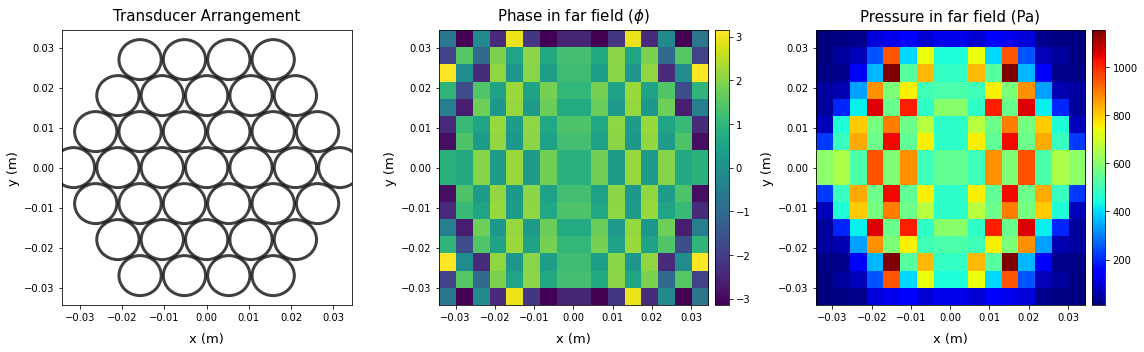

In [14]:

A = 1             # amplitude for each transducer to take (max=1, min=0)

d = 7             # diameter of hexagon [transducer units]

# evpd =  0.01025       # evaluation plane [m] transducer diameter + interspacing/2
# evpd = 0.008661       # evaluation plane [m] amm lambda Memoli
# evpd = 0.008575       # evaluation plane [m] amm lambda
# evpd = 0.072          # evaluation plane [m] width of central row of 7-hex-PAT board measured by ruler
# evpd = 0.08           # evaluation plane [m] 
# resolution = 2        # evaluation plane resolution [metamaterial unit cells]


# evpd = 2 * 0.008575   # evaluation plane [m] 2*lambda - 4*4 metasurface
# resolution = 4        # evaluation plane resolution [metamaterial unit cells]


# evpd = 4 * 0.008575   # evaluation plane [m] 4*lambda - 8*8 metasurface
# resolution = 8        # evaluation plane resolution [metamaterial unit cells]

evpd = 8 * 0.008575     # evaluation plane [m] 8*lambda - 16*16 metasurface
resolution = 16         # evaluation plane resolution [metamaterial unit cells]



# offset between board and metasurface [m]
# offset = 0.02       
# offset = 0.01715      # 2*lambda [m]
# offset = 0.01500625   # 1.75*lambda [m]
# offset = 0.0128625    # 1.5*lambda [m]
# offset = 0.01071875   # 1.25*lambda [m]
# offset = 0.008575     # 1*lambda [m]
# offset = 0.00643125   # 0.75*lambda [m]
offset = 0.0042875    # 0.5*lambda [m]
# offset = 0.00214375   # 0.25*lambda [m]

# calculate hexagon coordinates in XY plane 
coords = hexagon_diameter_to_coordinates( d, offset = offset )

def propagate( rxyz, rxy, wavelength = 343/40000 ): 

  k = 2 * np.pi / wavelength # rads/m

  H = piston_model_matrix(rxy, rxyz, k)

  phases = np.zeros( len(coords) ) # all transducer PHASES set to zero

  amplitudes = A * np.ones( len(coords) ) # all transducer AMPLITUDES set to A

  Pt = amplitudes * np.exp( 1j * phases ).reshape( len(coords) ) # transducer COMPLEX PRESSURE

  Pf = np.dot( H, Pt ).reshape( ( resolution, resolution ) ) # propagate to far field
  
  print(len(rxyz), len(rxy), resolution, len(coords))
  
  return Pf

Pf = propagate( *pesb_hex( coords, evpd, resolution ) )

# print(abs(Pf))

# print(len(coords))
plotter(Pf, evpd, coords)